In [1]:
import pandas as pd
import numpy as np
import missingno as msno
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    OrdinalEncoder,
    PowerTransformer,
    FunctionTransformer
)
from scipy.stats import norm
from sklearn.compose import ColumnTransformer
from sklearn.cluster import DBSCAN, OPTICS, KMeans

In [2]:
# Import data
df = pd.read_excel('/Users/kienguyen/Documents/DATA SCIENCE/Personal projects/customer segmentation/Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


## Data Cleaning

In [4]:
# Check missing values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
# Droping the columns with 70% or more missing data
perc_missing = 70.0 
min_count =  int(((100 - perc_missing)/100) * df.shape[1] + 1)
df = df.dropna(axis = 1, thresh = min_count)

In [6]:
# Check shape
df.shape

(541909, 8)

<Axes: >

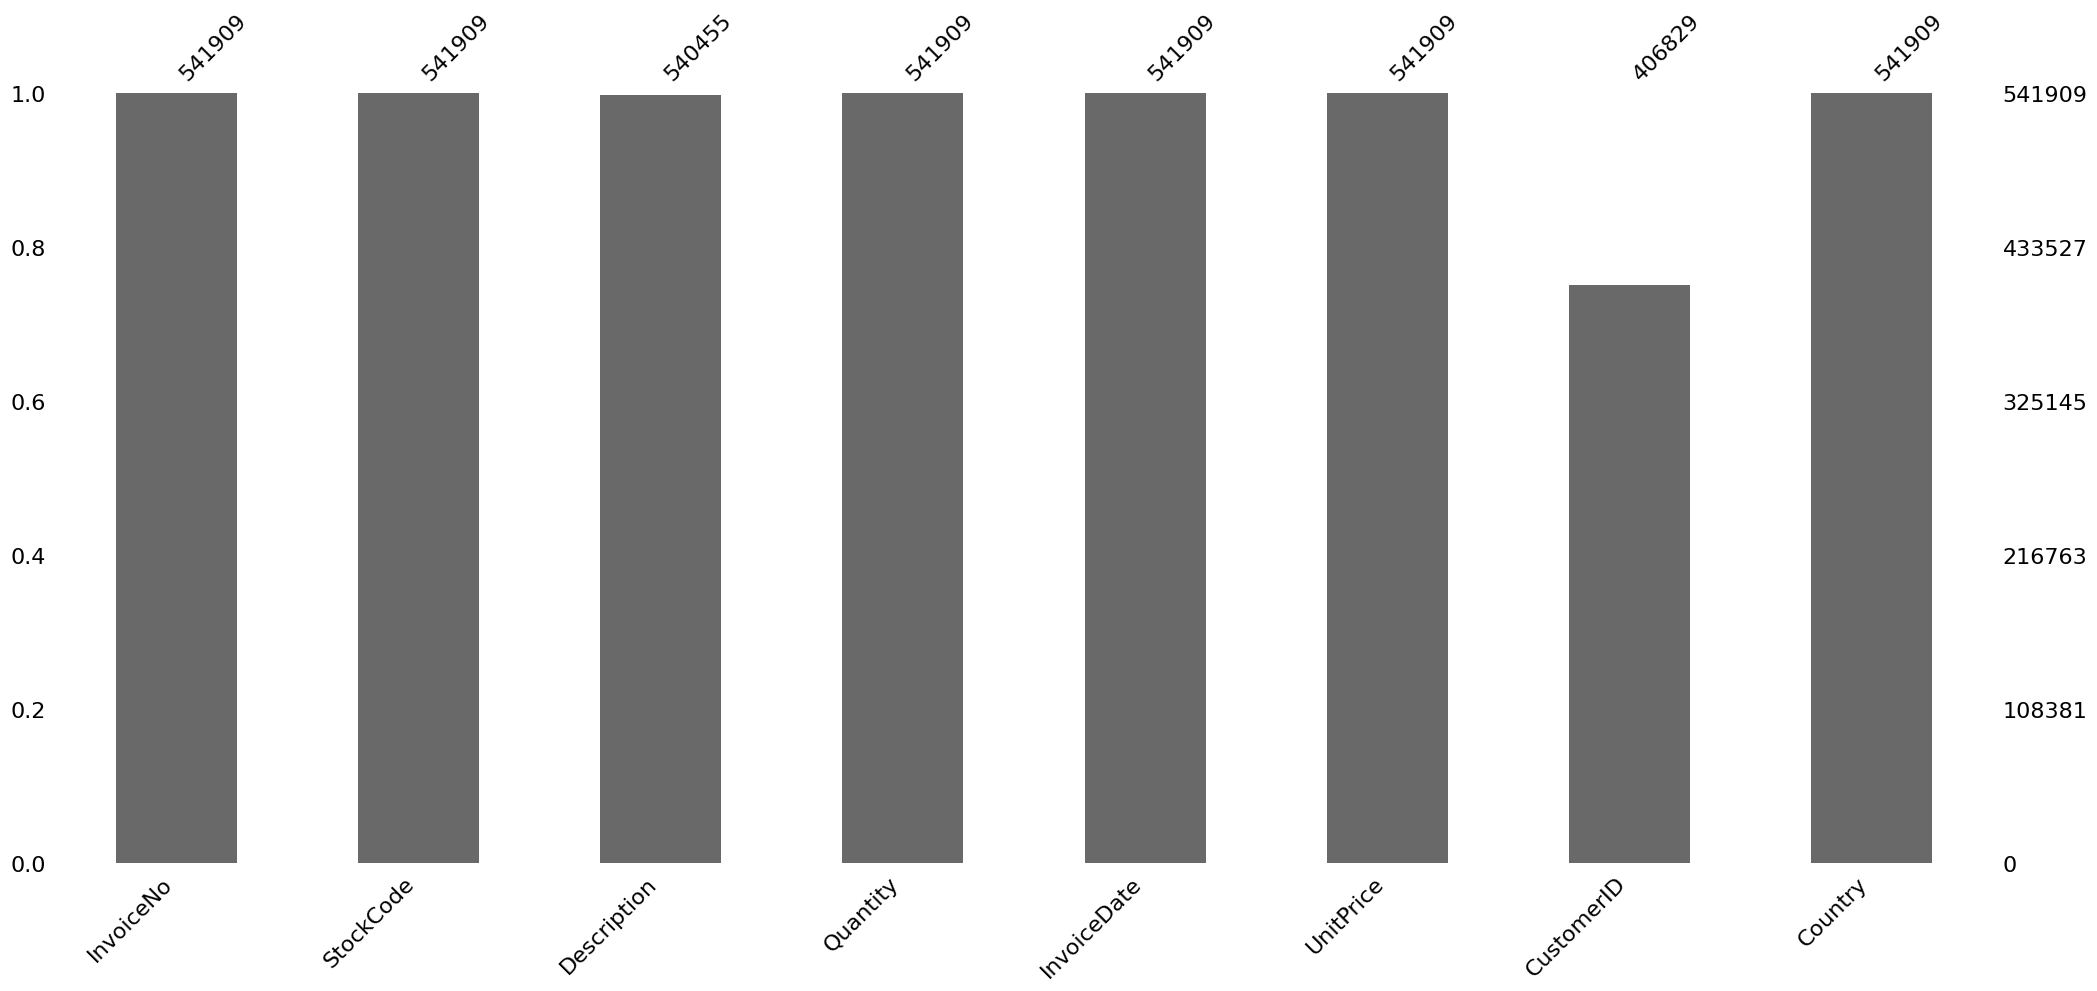

In [7]:
#Check missing values
msno.bar(df)

In [8]:
# Since we will proceed the customer segmentation so let us drop it instead of computing it. Besides, the percentage of missing is not major hence the dropping action will not cause imformation loss problem.
df = df.dropna(subset=['Description','CustomerID'])
df.shape

(406829, 8)

In [9]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [10]:
(df['Quantity'] <= 0).sum()

8905

The negative values of 'Quantity' mean that there are canceld invoices. We will not drop these samples since they are probably contributed to segmentation process. I will replace the negative into 0 and create new feature 'Canceled' column with categorical value 'Yes', 'No'.

In [11]:
# Create 'Canceled' column based on negative values on 'Quantity'
df['Canceled'] = df['Quantity'].apply(lambda x: 'Yes' if x <0 else 'No')
# Replace negative values by 0
df.loc[df['Quantity'] < 0] =0
# Remove rows where the value of Unitprice is 0:
df.drop(df[df['UnitPrice'] == 0].index, axis=0, inplace=True)
df.describe()

,Quantity,UnitPrice,CustomerID
count,397884.000000,397884.000000,397884.000000
mean,12.988238,3.116488,15294.423453
std,179.331775,22.097877,1713.141560
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13969.000000
50%,6.000000,1.950000,15159.000000
75%,12.000000,3.750000,16795.000000
max,80995.000000,8142.750000,18287.000000


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397884 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    397884 non-null  object 
 1   StockCode    397884 non-null  object 
 2   Description  397884 non-null  object 
 3   Quantity     397884 non-null  int64  
 4   InvoiceDate  397884 non-null  object 
 5   UnitPrice    397884 non-null  float64
 6   CustomerID   397884 non-null  float64
 7   Country      397884 non-null  object 
 8   Canceled     397884 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 30.4+ MB


In [13]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397884 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  object        
 8   Canceled     397884 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 30.4+ MB


In [14]:
# extracting time related features from InvoiceDate

df['InvoiceDateDay'] = df['InvoiceDate'].dt.date
df['InvoiceDateTime'] = df['InvoiceDate'].dt.time
df['InvoiceYear'] = df['InvoiceDate'].dt.year
df['InvoiceMonth'] = df['InvoiceDate'].dt.month
df['InvoiceMonthName'] = df['InvoiceDate'].dt.month_name()
df['InvoiceDay'] = df['InvoiceDate'].dt.day
df['InvoiceDayName'] = df['InvoiceDate'].dt.day_name()
df['InvoiceDayOfWeek'] = df['InvoiceDate'].dt.day_of_week
df['InvoiceWeekOfYear'] = df['InvoiceDate'].dt.weekofyear
df['InvoiceHour'] = df['InvoiceDate'].dt.hour

df['TotalValue'] = df['Quantity'] * df['UnitPrice']

In [15]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Canceled,InvoiceDateDay,InvoiceDateTime,InvoiceYear,InvoiceMonth,InvoiceMonthName,InvoiceDay,InvoiceDayName,InvoiceDayOfWeek,InvoiceWeekOfYear,InvoiceHour,TotalValue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,No,2010-12-01,08:26:00,2010,12,December,1,Wednesday,2,48,8,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,No,2010-12-01,08:26:00,2010,12,December,1,Wednesday,2,48,8,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,No,2010-12-01,08:26:00,2010,12,December,1,Wednesday,2,48,8,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,No,2010-12-01,08:26:00,2010,12,December,1,Wednesday,2,48,8,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,No,2010-12-01,08:26:00,2010,12,December,1,Wednesday,2,48,8,20.34


In [16]:
df['InvoiceYear'].unique()

array([2010, 2011])

## EDA

In [17]:
# EDA
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import plot
fig = make_subplots(rows=3, cols=2, specs=[[{"type": "bar"},{"type":"bar"}], 
                                           [{'type':'bar'},{"type":"bar"}],
                                           [{"colspan": 2},None]],
                    subplot_titles=("Total Quantity by year", "Number of Invoice by year",
                                    "Total Revenue of top 5 Country","Average Revenue by Day of Week","Total Revenue by Month of the Year"
                                    ))
a=df.groupby('InvoiceYear').sum().reset_index()
fig.add_trace(go.Bar(
     y=a['Quantity'],
     x=a['InvoiceYear'],
     name="Total Quantity"),
     row=1, col=1)
a=df.value_counts('InvoiceYear').reset_index()
fig.add_trace(go.Bar(
     y=a.iloc[:,1],
     x=a['InvoiceYear'],
     name="Invoice"),
     row=1, col=2)
a= df.groupby('Country')['TotalValue'].sum().sort_values(ascending=False).reset_index().head(5)
fig.add_trace(go.Bar(
     y=a['TotalValue'],
     x=a['Country'],
     name="Country"),
     row=2, col=1)
revenue_day = df.groupby(["InvoiceWeekOfYear", "InvoiceDayOfWeek", "InvoiceDayName"])["TotalValue"].sum().reset_index()
a=revenue_day.groupby(["InvoiceDayOfWeek", "InvoiceDayName"])["TotalValue"].mean().reset_index()
fig.add_trace(go.Bar(
     y=a['TotalValue'],
     x=a['InvoiceDayName'],
     name="Average revenue by Day of week"),
     row=2, col=2)
a= df.groupby(["InvoiceMonth", "InvoiceMonthName"])["TotalValue"].sum().reset_index()
fig.add_trace(go.Bar(
     y=a['TotalValue'],
     x=a['InvoiceMonthName'],
     name="Revenue by Month"),
     row=3, col=1)
fig.update_xaxes(title_text='Year', tickmode= 'array', tickvals = (2010,2011), row=1,col=1)
fig.update_xaxes(title_text = 'Year', tickmode= 'array', tickvals = (2010,2011), row=1,col=2)

fig.update_yaxes(title_text = 'Quantity of purchased items', row=1,col=1)
fig.update_yaxes(title_text='Number of invoice', row=1, col=2)


fig.update_layout(
    margin=dict(l=30, r=20, t=40, b=30),
    paper_bgcolor="LightSteelBlue",
    autosize=False,
    width=1350,
    height=1000,
    hovermode='closest',
    barmode='stack',
    title_text="Visualization for Sales Data",
    title_x=0.5,font=dict(size=12)
)

## Cohort analysis: Retention rate

In [18]:
import datetime as dt
def get_month(x): return dt.datetime(x.year,x.month,1)
df['InvMonth'] = df['InvoiceDate'].apply(get_month)
grouping = df.groupby('CustomerID')['InvMonth']
df['CohortMonth'] = grouping.transform('min')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Canceled,InvoiceDateDay,...,InvoiceMonth,InvoiceMonthName,InvoiceDay,InvoiceDayName,InvoiceDayOfWeek,InvoiceWeekOfYear,InvoiceHour,TotalValue,InvMonth,CohortMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,No,2010-12-01,...,12,December,1,Wednesday,2,48,8,15.30,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,No,2010-12-01,...,12,December,1,Wednesday,2,48,8,20.34,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,No,2010-12-01,...,12,December,1,Wednesday,2,48,8,22.00,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,No,2010-12-01,...,12,December,1,Wednesday,2,48,8,20.34,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,No,2010-12-01,...,12,December,1,Wednesday,2,48,8,20.34,2010-12-01,2010-12-01


In [19]:
def get_date_int(df,column):
    year = df[column].dt.year
    month = df[column].dt.month
    day= df[column].dt.day
    return year, month, day

invoice_year, invoice_month, _ = get_date_int(df, 'InvMonth')
cohort_year, cohort_month, _ = get_date_int(df, 'CohortMonth')
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month
df['CohortIndex'] = years_diff * 12 + months_diff +1
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Canceled,InvoiceDateDay,...,InvoiceMonthName,InvoiceDay,InvoiceDayName,InvoiceDayOfWeek,InvoiceWeekOfYear,InvoiceHour,TotalValue,InvMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,No,2010-12-01,...,December,1,Wednesday,2,48,8,15.30,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,No,2010-12-01,...,December,1,Wednesday,2,48,8,20.34,2010-12-01,2010-12-01,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,No,2010-12-01,...,December,1,Wednesday,2,48,8,22.00,2010-12-01,2010-12-01,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,No,2010-12-01,...,December,1,Wednesday,2,48,8,20.34,2010-12-01,2010-12-01,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,No,2010-12-01,...,December,1,Wednesday,2,48,8,20.34,2010-12-01,2010-12-01,1


In [20]:
grouping = df.groupby(['CohortMonth','CohortIndex'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique).reset_index()
cohort_counts = cohort_data.pivot(index = 'CohortMonth', columns = 'CohortIndex', values= 'CustomerID')
cohort_counts.head()

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02-01,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03-01,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04-01,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN


In [21]:
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.round(3)*100

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,36.6,32.3,38.4,36.3,39.8,36.3,34.9,35.4,39.5,37.4,50.3,26.6
2011-01-01,100.0,22.1,26.6,23.0,32.1,28.8,24.7,24.2,30.0,32.6,36.5,11.8,NaN
2011-02-01,100.0,18.7,18.7,28.4,27.1,24.7,25.3,27.9,24.7,30.5,6.8,NaN,NaN
2011-03-01,100.0,15.0,25.2,19.9,22.3,16.8,26.8,23.0,27.9,8.6,NaN,NaN,NaN
2011-04-01,100.0,21.3,20.3,21.0,19.7,22.7,21.7,26.0,7.3,NaN,NaN,NaN,NaN
2011-05-01,100.0,19.0,17.3,17.3,20.8,23.2,26.4,9.5,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,17.4,15.7,26.4,23.1,33.5,9.5,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,18.1,20.7,22.3,27.1,11.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,20.7,24.9,24.3,12.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


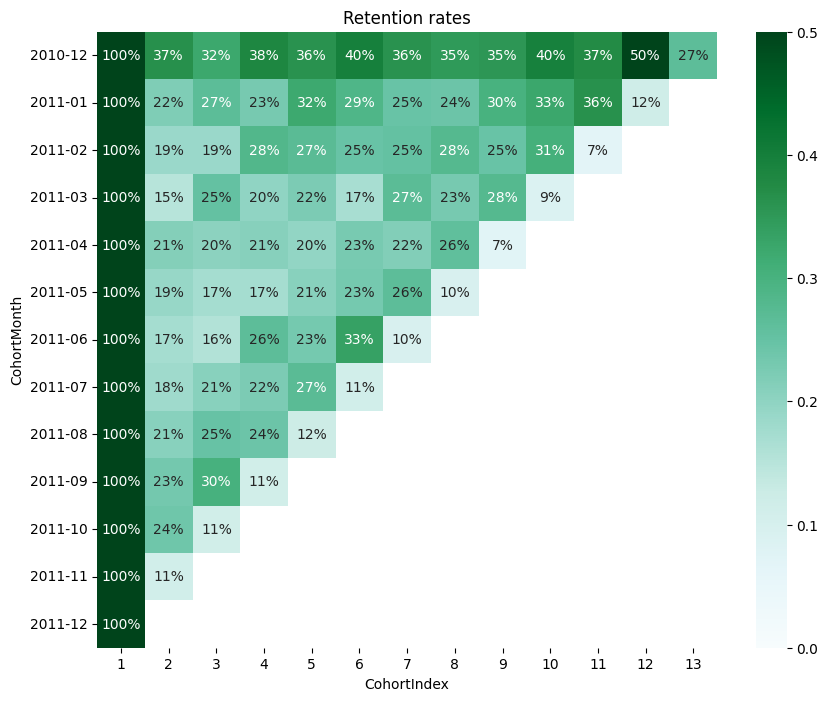

In [22]:
from datetime import datetime as dt
plt.figure(figsize=(10,8))
plt.title('Retention rates')
ytick_labels = [pd.to_datetime(label).strftime('%Y-%m') for label in retention.index]
sns.heatmap(data = retention, annot=True,fmt='.0%',vmin=0.0,vmax=0.5,cmap='BuGn',yticklabels=ytick_labels)
plt.show()

## RFM Analysis

In [23]:
ref_date = df["InvoiceDateDay"].max() + timedelta(days=1)
df_customers = df.groupby("CustomerID").agg({
    "InvoiceDateDay": lambda x : (ref_date - x.max()).days,
    "InvoiceNo": "count",
    "TotalValue": "sum",
    "Quantity": "sum",
    "Canceled": lambda x : (x=="Yes").count()
}).rename(columns={
    "InvoiceDateDay": "Recency",
    "InvoiceNo": "Frequency",
    "TotalValue": "MonetaryValue",
    "Quantity": "Quantity of purchased items",
    "Canceled": "Cancelation history"
})
df_customers.head()

,Recency,Frequency,MonetaryValue,Quantity of purchased items,Cancelation history
CustomerID,,,,,
12346.0,326,1,77183.60,74215,1
12347.0,3,182,4310.00,2458,182
12348.0,76,31,1797.24,2341,31
12349.0,19,73,1757.55,631,73
12350.0,311,17,334.40,197,17


In [24]:
r_labels = range(4,0,-1)
r_quartiles = pd.qcut(df_customers['Recency'],4,labels=r_labels)
df_customers = df_customers.assign(R = r_quartiles.values)
df_customers.head()

,Recency,Frequency,MonetaryValue,Quantity of purchased items,Cancelation history,R
CustomerID,,,,,,
12346.0,326,1,77183.60,74215,1,1
12347.0,3,182,4310.00,2458,182,4
12348.0,76,31,1797.24,2341,31,2
12349.0,19,73,1757.55,631,73,3
12350.0,311,17,334.40,197,17,1


In [25]:
f_labels = range(1,5)
m_labels = range(1,5)
f_quartiles = pd.qcut(df_customers["Frequency"],4,labels = f_labels)
m_quartiles = pd.qcut(df_customers["MonetaryValue"],4,labels = m_labels)
df_customers = df_customers.assign(F=f_quartiles.values)
df_customers = df_customers.assign(M=m_quartiles.values)
df_customers.head()

,Recency,Frequency,MonetaryValue,Quantity of purchased items,Cancelation history,R,F,M
CustomerID,,,,,,,,
12346.0,326,1,77183.60,74215,1,1,1,4
12347.0,3,182,4310.00,2458,182,4,4,4
12348.0,76,31,1797.24,2341,31,2,2,4
12349.0,19,73,1757.55,631,73,3,3,4
12350.0,311,17,334.40,197,17,1,1,2


In [26]:
# Build RFM segment and RFM score
def join_rfm(x): return str(x['R']) + str(x['F'])+str(x['M'])
df_customers['RFM_Segment'] = df_customers.apply(join_rfm,axis=1)
df_customers['RFM_Score'] = df_customers[['R','F','M']].sum(axis=1)
df_customers.head()

,Recency,Frequency,MonetaryValue,Quantity of purchased items,Cancelation history,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,,,
12346.0,326,1,77183.60,74215,1,1,1,4,1.01.04.0,6
12347.0,3,182,4310.00,2458,182,4,4,4,4.04.04.0,12
12348.0,76,31,1797.24,2341,31,2,2,4,2.02.04.0,8
12349.0,19,73,1757.55,631,73,3,3,4,3.03.04.0,10
12350.0,311,17,334.40,197,17,1,1,2,1.01.02.0,4


In [27]:
df_customers.groupby('RFM_Score').agg({'Recency':'mean','Frequency':'mean','MonetaryValue':['mean','count']}).round(1)

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3           261.4       8.2         159.3   385
4           175.2      13.7         239.0   385
5           154.3      21.4         368.7   517
6            96.6      28.0         823.8   464
7            80.3      38.7         760.4   452
8            64.7      57.0         994.1   459
9            46.6      80.1        1810.7   413
10           32.6     112.7        2058.3   428
11           21.4     188.0        4071.8   395
12            7.6     377.7        9427.5   440

In [28]:
def segment_me(df):
    if df['RFM_Score'] >=9:
        return '1.Gold'
    elif (df['RFM_Score'] >=5) and (df['RFM_Score']<9):
        return '2.Silver'
    else:
        return '3.Bronze'
df_customers['General_Segment'] = df_customers.apply(segment_me,axis=1)
df_customers.groupby('General_Segment').agg({'Recency':'mean','Frequency':'mean','MonetaryValue':['mean','count']}).round(1)

Recency Frequency MonetaryValue      
                   mean      mean          mean count
General_Segment                                      
1.Gold             26.9     192.0        4406.5  1676
2.Silver          100.7      35.8         725.6  1892
3.Bronze          218.3      11.0         199.2   770

## K-Mean clustering

### Pre-processing data

In [29]:
df_customers_rfm = df_customers[['Recency','Frequency','MonetaryValue','Quantity of purchased items','Cancelation history']]

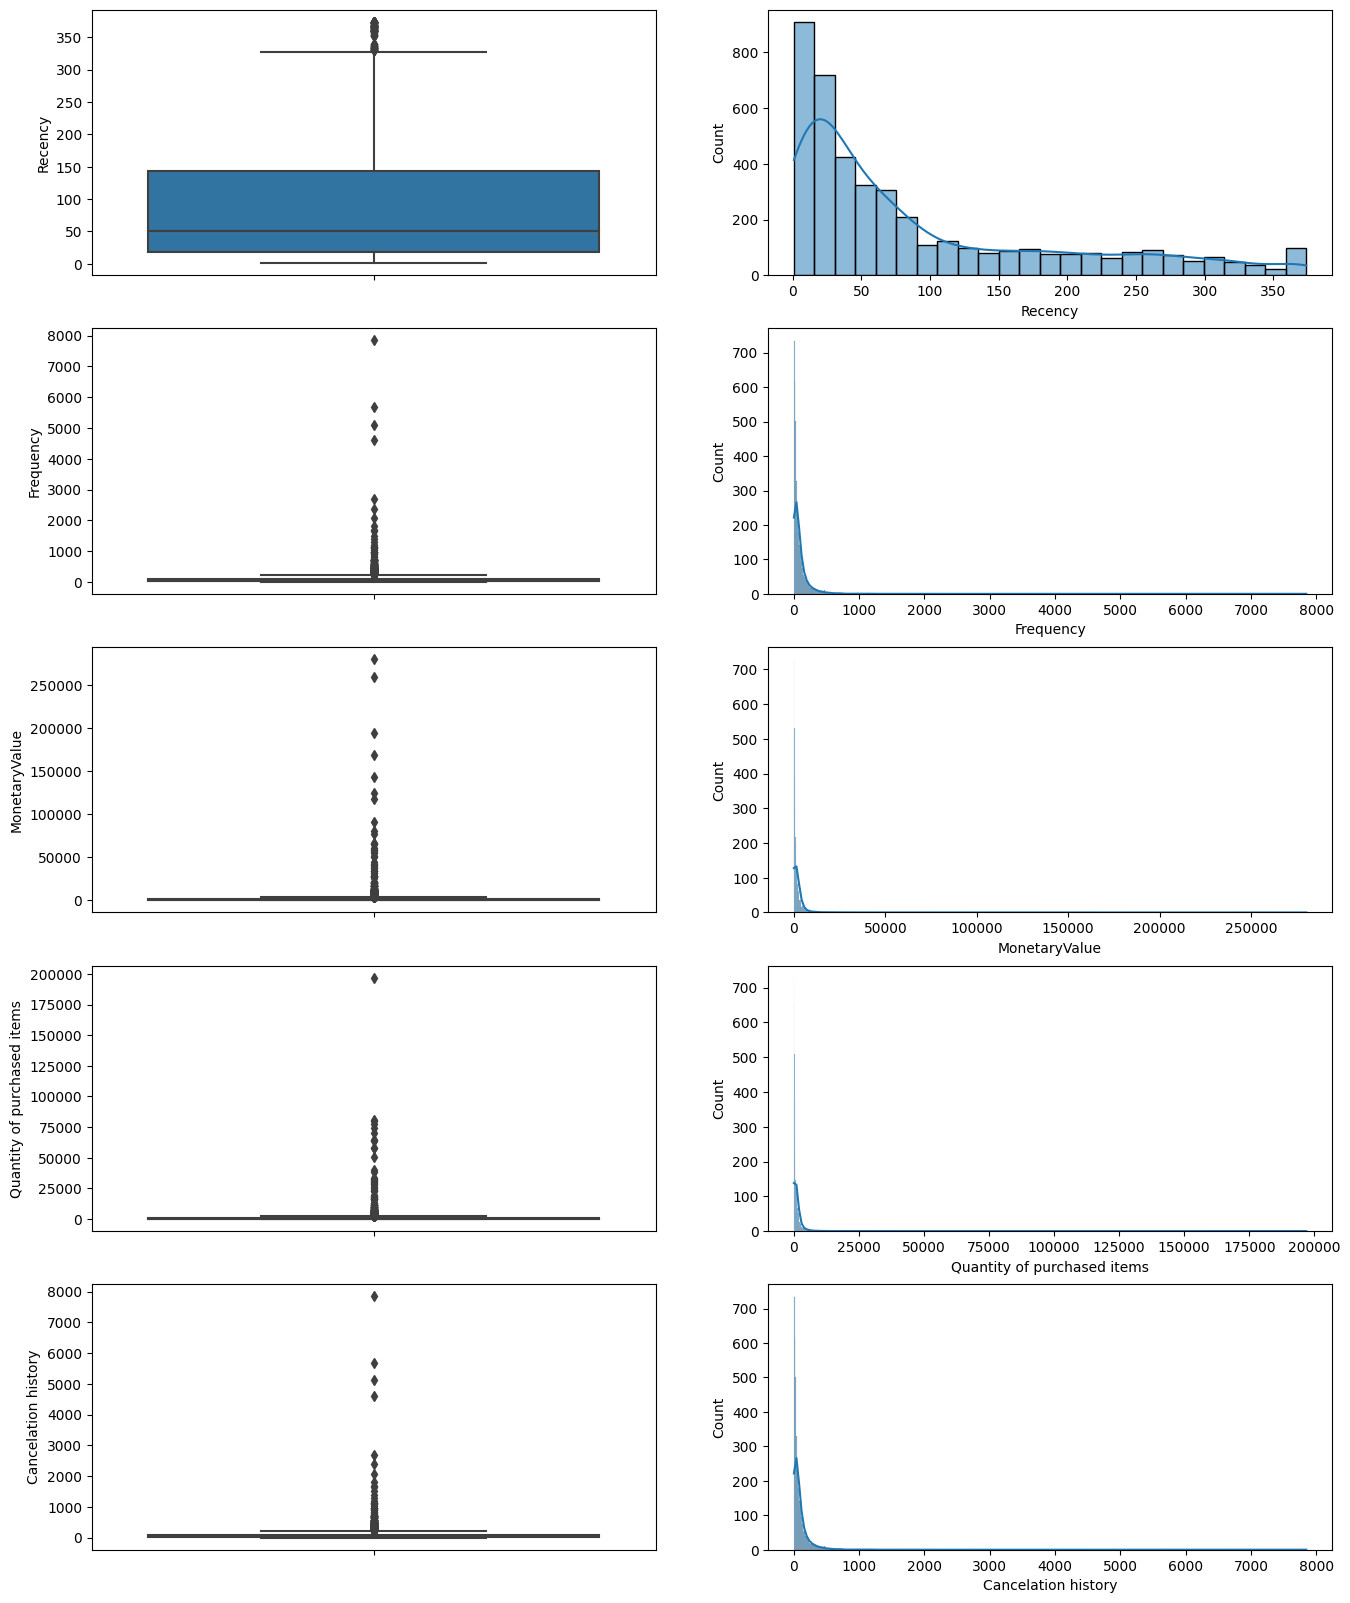

In [30]:
n_cols = len(df_customers_rfm.columns)
fig, axes = plt.subplots(n_cols, 2, figsize=(16, n_cols * 4))

for i, col in enumerate(df_customers_rfm.columns):
    sns.boxplot(data=df_customers_rfm, y=col, ax=axes[i][0])
    sns.histplot(data=df_customers_rfm, x=col, kde=True, ax=axes[i][1])

fig.show()

In [31]:
def remove_outliers(df, col, threshold=1.5):
    Q1 = np.quantile(df[col], .25)
    Q3 = np.quantile(df[col], .75)
    IQR = Q3 - Q1
    df.drop(df[(df[col] < (Q1 - threshold * IQR)) | (df[col] > (Q3 + threshold * IQR))].index, axis=0, inplace=True)
    
    return df

for col in df_customers_rfm.columns:
    size_before = len(df_customers_rfm)
    df_customers = remove_outliers(df_customers_rfm, col)
    print(f"Removed {size_before - len(df_customers_rfm)} outliers from {col}")

Removed 155 outliers from Recency
Removed 367 outliers from Frequency
Removed 312 outliers from MonetaryValue
Removed 201 outliers from Quantity of purchased items
Removed 162 outliers from Cancelation history


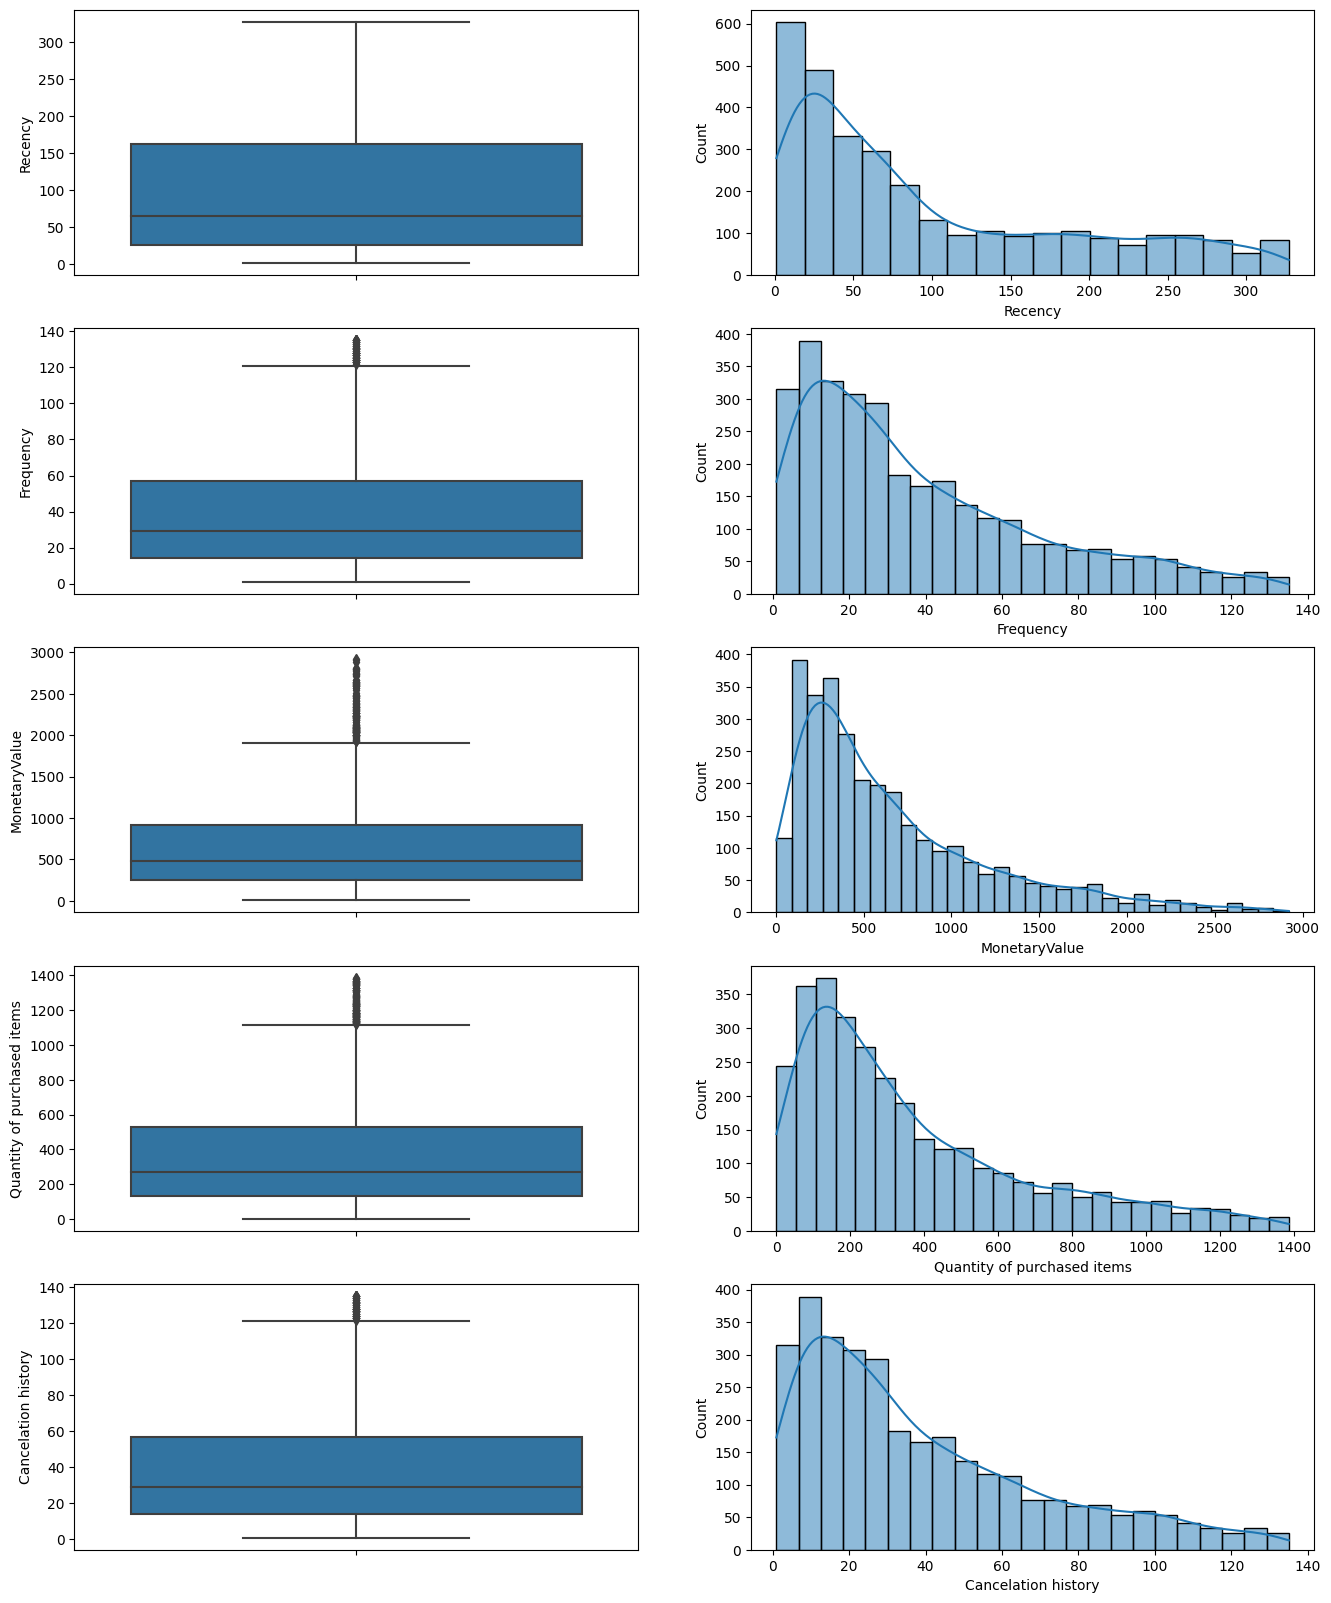

In [32]:
n_cols = len(df_customers_rfm.columns)
fig, axes = plt.subplots(n_cols, 2, figsize=(16, n_cols * 4))

for i, col in enumerate(df_customers_rfm.columns):
    sns.boxplot(data=df_customers_rfm, y=col, ax=axes[i][0])
    sns.histplot(data=df_customers_rfm, x=col, kde=True, ax=axes[i][1])

fig.show()

In [33]:
# defining some feature transformers
X=df_customers_rfm

boxcox_t = PowerTransformer(method="box-cox")
log_t = FunctionTransformer(func=np.log, inverse_func=np.exp)
sqrt_t = FunctionTransformer(func=np.sqrt, inverse_func=lambda x : x ** 2)
cbrt_t = FunctionTransformer(func=np.cbrt, inverse_func=lambda x : x ** 3)

X_boxcox = boxcox_t.fit_transform(X)
X_log = log_t.fit_transform(X).values
X_sqrt = sqrt_t.fit_transform(X).values
X_cbrt = cbrt_t.fit_transform(X).values

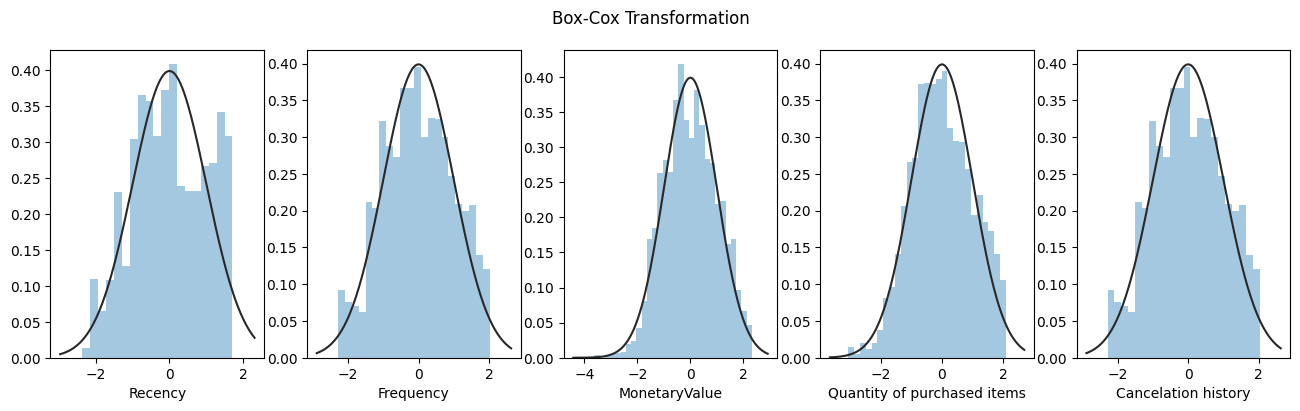

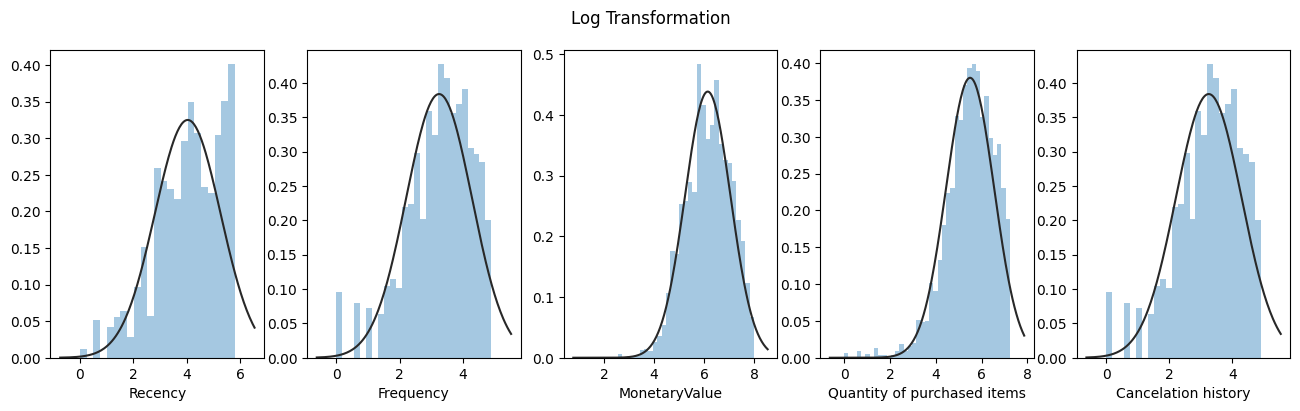

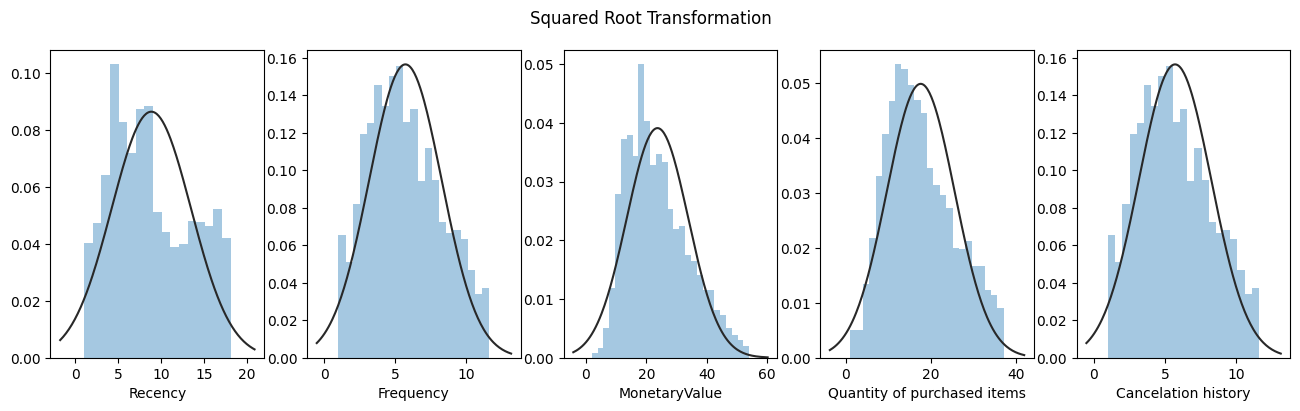

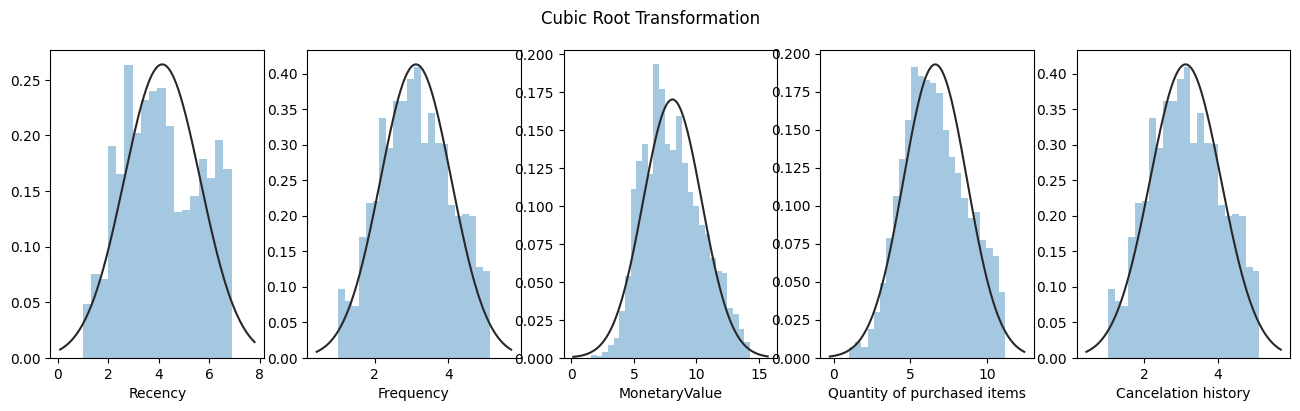

In [34]:
fig, axes = plt.subplots(1, 5, figsize=(16, 4))
fig.suptitle("Box-Cox Transformation")
for i in range(5):
    ax = axes[i]
    sns.distplot(X_boxcox[:,i], fit=norm, kde=False, ax=ax)
    ax.set_xlabel(df_customers_rfm.columns[i])
    
fig, axes = plt.subplots(1, 5, figsize=(16, 4))
fig.suptitle("Log Transformation")
for i in range(5):
    ax = axes[i]
    sns.distplot(X_log[:,i], fit=norm, kde=False, ax=ax)
    ax.set_xlabel(df_customers_rfm.columns[i])
    
fig, axes = plt.subplots(1, 5, figsize=(16, 4))
fig.suptitle("Squared Root Transformation")
for i in range(5):
    ax = axes[i]
    sns.distplot(X_sqrt[:,i], fit=norm, kde=False, ax=ax)
    ax.set_xlabel(df_customers_rfm.columns[i])
    
fig, axes = plt.subplots(1, 5, figsize=(16, 4))
fig.suptitle("Cubic Root Transformation")
for i in range(5):
    ax = axes[i]
    sns.distplot(X_cbrt[:,i], fit=norm, kde=False, ax=ax)
    ax.set_xlabel(df_customers_rfm.columns[i])

In [35]:
standard_scaler = StandardScaler()

transformers = ColumnTransformer(
    [
        ("boxcox", boxcox_t, ["Frequency",'Quantity of purchased items']),
        ("cbrt", cbrt_t, ["Recency", "MonetaryValue",'Cancelation history'])
    ],
    remainder="passthrough"
)

preprocessing = Pipeline([
    ("transformers", transformers),
    ("scaler", standard_scaler),
])

In [36]:
import random
seed = 42
random.seed(seed)
np.random.seed(seed)

In [37]:
kmeans = KMeans(random_state=seed)

clusterer = Pipeline([
    ("preprocessing", preprocessing),
    ("kmeans", kmeans)
])

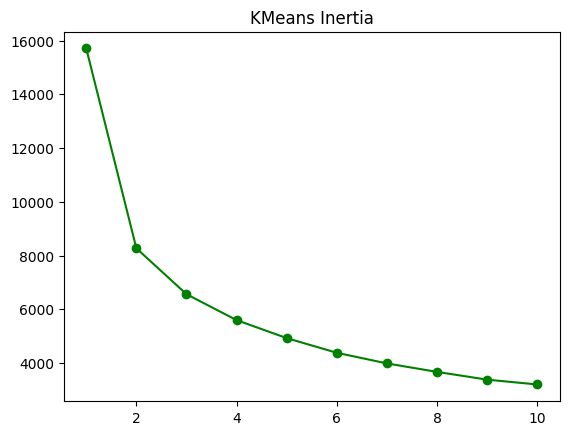

In [38]:
n_clusters = np.arange(1, 11)
inertia = []
for k in n_clusters:
    kmeans = clusterer.steps[-1][1]
    kmeans.set_params(n_clusters=k)
    clusterer.fit(X)
    inertia.append(kmeans.inertia_)
    
plt.title("KMeans Inertia")
plt.plot(n_clusters, inertia, color="green", marker="o")
plt.show()

In [39]:
model_k2 = KMeans(n_clusters=2, random_state=seed)
model_k2.fit(df_customers_rfm)
cluster_labels_2=model_k2.labels_

# k=3
model_k3 = KMeans(n_clusters=3, random_state=seed)
model_k3.fit(df_customers_rfm)
cluster_labels_3=model_k3.labels_

In [40]:
# k=2
df_customers_rfm_k2 = df_customers_rfm.assign(Cluster = cluster_labels_2)
df_customers_rfm_k2.groupby(['Cluster']).agg({'Recency':'mean','Frequency':'mean','MonetaryValue':['mean','count'],'Quantity of purchased items':'mean','Cancelation history':'mean'}).round(0)


Recency Frequency MonetaryValue       Quantity of purchased items  \
           mean      mean          mean count                        mean   
Cluster                                                                     
0         112.0      30.0         402.0  2387                       235.0   
1          59.0      68.0        1498.0   754                       818.0   

        Cancelation history  
                       mean  
Cluster                      
0                      30.0  
1                      68.0

In [41]:
# k=3
df_customers_rfm_k3 = df_customers_rfm.assign(Cluster = cluster_labels_3)
df_customers_rfm_k3.groupby(['Cluster']).agg({'Recency':'mean','Frequency':'mean','MonetaryValue':['mean','count'],'Quantity of purchased items':'mean','Cancelation history':'mean'}).round(0)


Recency Frequency MonetaryValue       Quantity of purchased items  \
           mean      mean          mean count                        mean   
Cluster                                                                     
0         122.0      24.0         299.0  1839                       171.0   
1          53.0      78.0        1827.0   404                       955.0   
2          74.0      52.0         892.0   898                       530.0   

        Cancelation history  
                       mean  
Cluster                      
0                      24.0  
1                      78.0  
2                      52.0

## Persona for segmentation

In [42]:
segment_prep = df_customers_rfm[['Recency', 'Frequency', 'MonetaryValue', 'Quantity of purchased items','Cancelation history']]

In [43]:
clusterer = Pipeline([
    ("kmeans", model_k2)
])
pipe=Pipeline([('preprocessing',preprocessing),('clusterer',clusterer)])

_ = pipe.fit(segment_prep)

In [44]:
col_names = list(['Recency', 'Frequency', 'MonetaryValue', 'Quantity of purchased items',
       'Cancelation history'])
segments = pd.DataFrame(preprocessing['transformers'].transform(segment_prep), columns=col_names, index=segment_prep.index)
segments_k2 = segments.copy()
segments_k2 = segments.assign(Cluster = pipe['clusterer']["kmeans"].labels_)
#segments_k3 = segments_k3.assign(CustomerID = segment_prep.index)

clusters = {0: 'On-purpose purchasers',  1: 'Addictive Purchasers'} 
# 2: 'Maintaning purchasers',
segments_k2['Cluster'] = segments_k2['Cluster'].replace(clusters)

In [45]:
segments_k2.reset_index()
segments_k2

,Recency,Frequency,MonetaryValue,Quantity of purchased items,Cancelation history,Cluster
CustomerID,,,,,,
12349.0,1.090507,0.951314,2.668402,12.068017,4.179339,Addictive Purchasers
12350.0,-0.551533,-0.350498,6.775169,6.941001,2.571282,On-purpose purchasers
12352.0,1.306212,0.743799,3.332222,13.583009,4.396830,Addictive Purchasers
12353.0,-1.614581,-1.988907,5.896369,4.464745,1.587401,On-purpose purchasers
12354.0,0.782305,0.729810,6.153449,10.257955,3.870877,Addictive Purchasers
...,...,...,...,...,...,...
18277.0,-1.161463,-1.235702,3.892996,4.796931,2.000000,On-purpose purchasers
18278.0,-1.074849,-1.257127,4.198336,5.581700,2.080084,On-purpose purchasers
18280.0,-0.994783,-1.517494,6.526519,5.652483,2.154435,On-purpose purchasers


In [46]:
df_melt = pd.melt(segments_k2.reset_index(),id_vars=['CustomerID','Cluster'],value_vars=['Recency','Frequency','MonetaryValue','Quantity of purchased items','Cancelation history'],
    var_name='Attribute',value_name='Value')
df_melt.head()

,CustomerID,Cluster,Attribute,Value
0,12349.0,Addictive Purchasers,Recency,1.090507
1,12350.0,On-purpose purchasers,Recency,-0.551533
2,12352.0,Addictive Purchasers,Recency,1.306212
3,12353.0,On-purpose purchasers,Recency,-1.614581
4,12354.0,Addictive Purchasers,Recency,0.782305


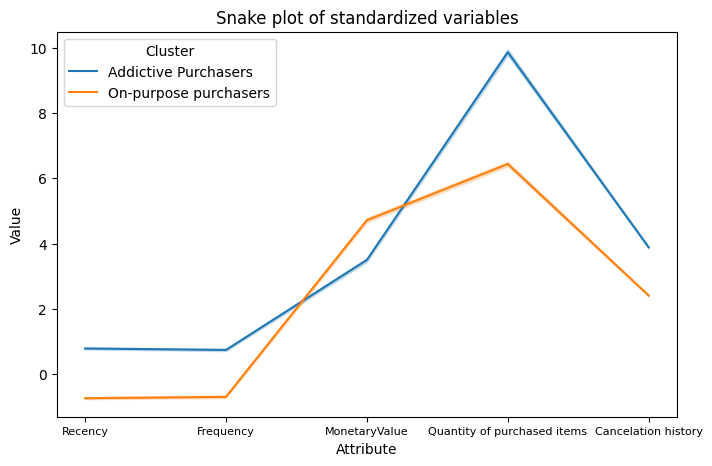

In [55]:

df_melt = pd.melt(segments_k2.reset_index(),id_vars=['CustomerID','Cluster'],value_vars=['Recency','Frequency','MonetaryValue','Quantity of purchased items','Cancelation history'],
    var_name='Attribute',value_name='Value')
    
# Snake plot
plt.figure(figsize=(8,5))
plt.title('Snake plot of standardized variables')
sns.lineplot(x='Attribute',y='Value',hue='Cluster',data=df_melt)
plt.xticks(fontsize=8)

plt.show()

## Direction to invest marketing activities on different segmentation customers

In [48]:
df_join = pd.merge(df,df_melt[['CustomerID','Cluster']], on='CustomerID', how='inner')
df_join.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Canceled,InvoiceDateDay,...,InvoiceDay,InvoiceDayName,InvoiceDayOfWeek,InvoiceWeekOfYear,InvoiceHour,TotalValue,InvMonth,CohortMonth,CohortIndex,Cluster
0,536371,22086,PAPER CHAIN KIT 50'S CHRISTMAS,80,2010-12-01 09:00:00,2.55,13748.0,United Kingdom,No,2010-12-01,...,1,Wednesday,2,48,9,204.0,2010-12-01,2010-12-01,1,Addictive Purchasers
1,536371,22086,PAPER CHAIN KIT 50'S CHRISTMAS,80,2010-12-01 09:00:00,2.55,13748.0,United Kingdom,No,2010-12-01,...,1,Wednesday,2,48,9,204.0,2010-12-01,2010-12-01,1,Addictive Purchasers
2,536371,22086,PAPER CHAIN KIT 50'S CHRISTMAS,80,2010-12-01 09:00:00,2.55,13748.0,United Kingdom,No,2010-12-01,...,1,Wednesday,2,48,9,204.0,2010-12-01,2010-12-01,1,Addictive Purchasers
3,536371,22086,PAPER CHAIN KIT 50'S CHRISTMAS,80,2010-12-01 09:00:00,2.55,13748.0,United Kingdom,No,2010-12-01,...,1,Wednesday,2,48,9,204.0,2010-12-01,2010-12-01,1,Addictive Purchasers
4,536371,22086,PAPER CHAIN KIT 50'S CHRISTMAS,80,2010-12-01 09:00:00,2.55,13748.0,United Kingdom,No,2010-12-01,...,1,Wednesday,2,48,9,204.0,2010-12-01,2010-12-01,1,Addictive Purchasers


In [49]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=3, cols=2, specs=[[{"type": "bar"},{"type":"bar"}], 
                                           [{"colspan": 2},None],
                                           [{"colspan": 2},None]],
                    subplot_titles=("Total Quantity by Segmentation", "Total Revenue by Segmentation",
                                    "Total Revenue by Day of Week by Segment","Total Revenue by Month of each Segment"
                                    ))
a = df_join.groupby('Cluster').sum().reset_index()

colors = ['royalblue','palevioletred','tan'] 

for i, cluster in enumerate(a['Cluster'].unique()):
     data = a[a['Cluster'] == cluster]
     fig.add_trace(go.Bar(y=data['Quantity'], name=cluster, marker=dict(color=colors[i])), row=1, col=1)

a = df_join.groupby('Cluster').sum().reset_index()
for i, cluster in enumerate(a['Cluster'].unique()):
     data = a[a['Cluster'] == cluster]
     fig.add_trace(go.Bar(y=data['TotalValue'], name=cluster, marker=dict(color=colors[i])), row=1, col=2)

revenue_day = df_join.groupby(["InvoiceWeekOfYear", "InvoiceDayOfWeek", "InvoiceDayName",'Cluster'])["TotalValue"].sum().reset_index()
a = revenue_day.groupby(["InvoiceDayOfWeek", "InvoiceDayName",'Cluster'])["TotalValue"].mean().reset_index()
for i, cluster in enumerate(a['Cluster'].unique()):
     data = a[a['Cluster'] == cluster]
     fig.add_trace(go.Scatter(x=data['InvoiceDayName'], y=data['TotalValue'], name=cluster, marker=dict(color=colors[i])), row=2, col=1)

a = df_join.groupby(["InvoiceMonth", "InvoiceMonthName",'Cluster'])["TotalValue"].sum().reset_index()
for i, cluster in enumerate(a['Cluster'].unique()):
     data = a[a['Cluster'] == cluster]
     fig.add_trace(go.Bar(x=data['InvoiceMonthName'], y=data['TotalValue'], name=cluster, marker=dict(color=colors[i])), row=3, col=1)

fig.update_xaxes(tickmode=None,tickvals=[], ticktext=[], row=1,col=1)
fig.update_xaxes(tickmode=None,tickvals=[], ticktext=[], row=1,col=2)



fig.update_layout(
    margin=dict(l=30, r=20, t=40, b=30),
    paper_bgcolor="LightSteelBlue",
    autosize=False,
    width=1350,
    height=1000,
    hovermode='closest',
    barmode='stack',
    title_text="Data by Segmentation",
    title_x=0.5,
    font=dict(size=12)
)
fig.show()
